# Lab 4: Gaussian Process Regression and optimization

In [32]:
% pylab inline
import numpy as np
import pandas as pd
import pylab as pb
import GPy
import seaborn as sns
import scipy as sp
pb.ion()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


First we'll analize de gathered data to determine the noise fo he measurements

<class 'pandas.core.frame.DataFrame'>


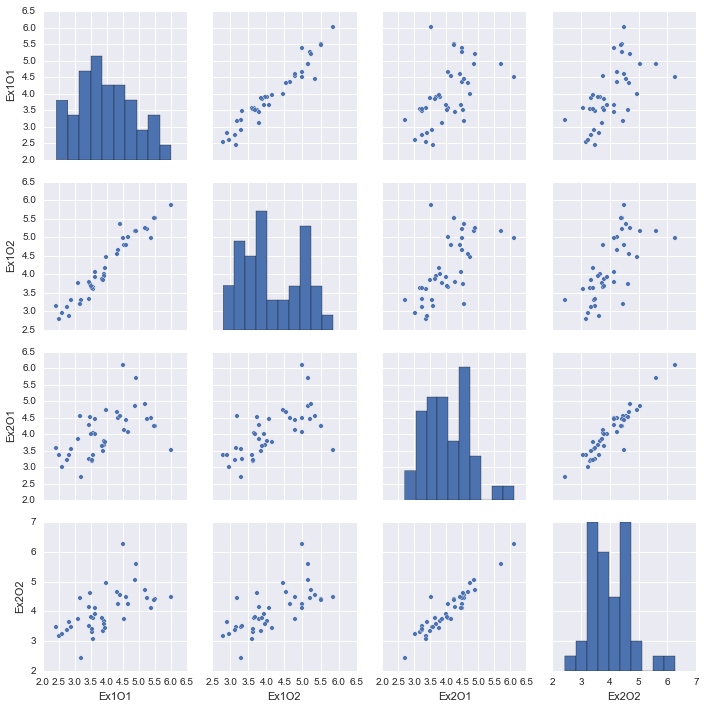

In [2]:
df = pd.read_csv('helicopterTrials.csv',names=['Ex1O1', 'Ex1O2', 'Ex2O1', 'Ex2O2']) # Falling times load
print type(df) 
sns.pairplot(df)

In [91]:
#exp1 = np.array(df[['Ex1O1', 'Ex1O2']])
#exp2 = np.array(df[['Ex2O1', 'Ex2O2']])
new_data_time = np.array([4.98, 5.07])
new_data = np.array([[  6.50098425 ,  4.45364863,   7.95281359 , 12.47233836, -1.0*np.mean(new_data_time)]])

[[  4.27171027   7.65321279   9.07186196   9.34873546  -4.4925    ]
 [  6.90945077   4.06355353  10.92089312  12.01580996  -3.85      ]
 [  7.31114173   2.73555085   7.52882764  10.39079986  -3.7825    ]
 [  9.15365389   2.7311498    8.22103368  12.24069704  -3.3025    ]
 [  6.49203258   3.49540878   7.4644955    9.88962577  -2.9075    ]
 [  7.42647304   2.74485819   7.69520087  10.80140301  -2.965     ]
 [  5.53892078   4.65239201   9.05593051  10.40514871  -3.6225    ]
 [  7.30272914   4.21338792   8.92179113  11.5447105   -4.4425    ]
 [  7.85092871   3.82120398   9.71286737  12.513127    -4.745     ]
 [  5.30371801   6.45410807   8.60162249  10.17158257  -3.415     ]
 [  6.60715697   4.71516664   8.07144047  10.78294101  -3.76      ]
 [  7.76607629   2.82292835   8.33016314  11.90376057  -2.96      ]
 [  4.6865547    5.00613776   8.38649383   9.85002839  -4.725     ]
 [  7.42152297   3.21310787   9.1691105   12.33244345  -3.405     ]
 [  6.95087249   3.87333777   7.05220868  10.766

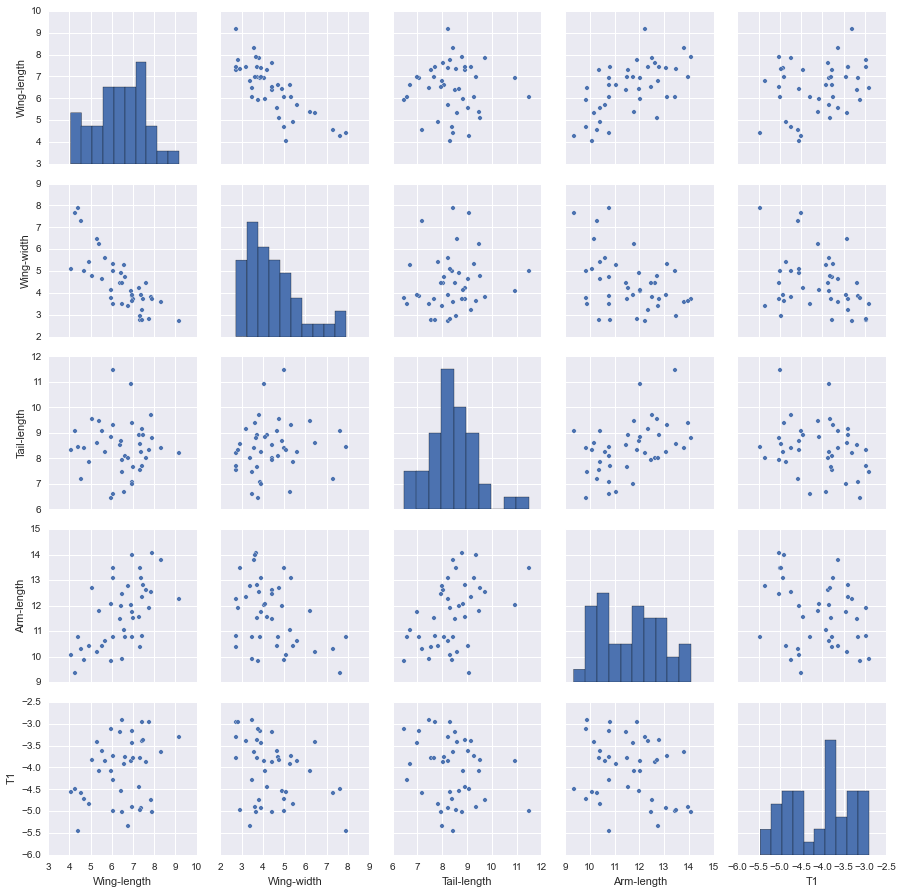

In [92]:
superexp = np.array(df[['Ex1O1', 'Ex1O2', 'Ex2O1', 'Ex2O2']])
superexp = np.mean(superexp, axis=1)[:,None]
#exp1 = np.mean(exp1, axis=1)
#exp2 = np.mean(exp2, axis=1)
data = np.loadtxt('X.csv', delimiter=',')
#exp1 = exp1[:,None]
#exp2 = exp2[:,None]
data = np.hstack((data[0:40,:], -1.0*superexp)) # We multiply by minus one because we want to maximize
data = np.vstack((data, new_data))
names = ["Wing-length", "Wing-width", "Tail-length", "Arm-length", "T1"]
dataplot = pd.DataFrame(data=data, columns=names)
sns.pairplot(dataplot)
print data

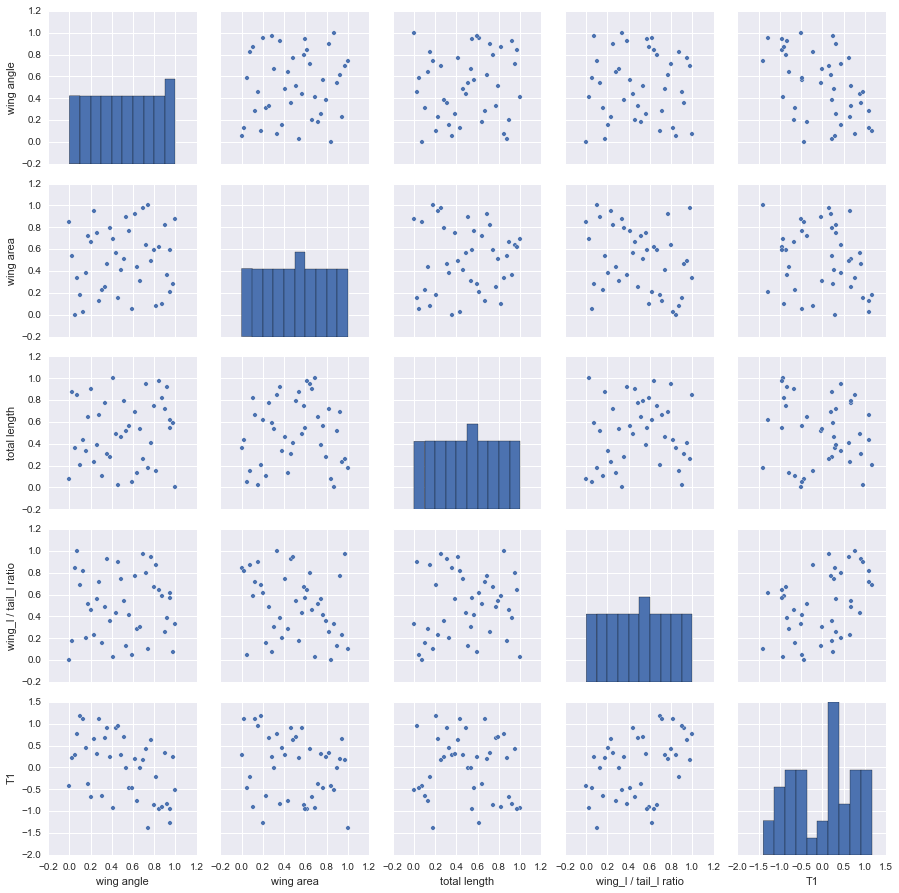

In [93]:

##################################################################
##                           helpers                            ##
##################################################################

## coordinate change

def angle(X):
    # input X is ["Wing-length", "Wing-width", "Tail-length", "Arm-length"]
    # output is the angle (in degrees) between the tail and the wing
    return(180/np.pi*np.arccos(-1.*((X[:,3]-2.5)**2-(X[:,2]-2.5)**2-X[:,0]**2)/(2*(X[:,2]-2.5)*X[:,0])))

# mapping to the new space
def old2new(X):
    # input X is ["Wing-length", "Wing-width", "Tail-length", "Arm-length"]
    # output Y is ['wing angle', 'wing area','total length', 'wing_l / tail_l ratio']
    Y = 0*X
    Y[:,0] = angle(X)
    Y[:,1] = X[:,0] * X[:,1]  
    Y[:,2] = X[:,0] + X[:,2] + X[:,3] 
    Y[:,3] = X[:,0] / (X[:,2] - 2.5)
    return(Y)

# mapping back to the original space
def new2old(Y):
    # input Y is ['wing angle', 'wing area','total length', 'wing_l / tail_l ratio']
    # output X is ["Wing-length", "Wing-width", "Tail-length", "Arm-length"]
    X = 0*Y
    f_1 = np.sqrt(1+(1/Y[:,3])**2-2*np.cos(Y[:,0]*np.pi/180)*(1/Y[:,3]))
    X[:,0] = (Y[:,2]-5) / (1 + 1./Y[:,3] + f_1)
    X[:,1] = Y[:,1] / X[:,0]
    X[:,2] = X[:,0] / Y[:,3] + 2.5
    X[:,3] = Y[:,2] - X[:,0] - X[:,2]
    return(X)

## error measures

def Q2(F,mX):
	return(1-sum((F-mX)**2)/sum((F-np.mean(F))**2))

def leaveOneOut(m):
    n = m.X.shape[0]
    mean = np.zeros(n)
    var = np.zeros(n)
    kern = m.kern
    for i in range(n):
        Xloo = np.delete(m.X,i,0)
        Yloo = np.delete(m.Y,i,0)
        mloo = GPy.models.gp_regression.GPRegression(Xloo, Yloo, kern.copy())
        mloo[:] = m[:]
        mean[i],var[i] = mloo.predict(X[i:i+1,:])
    return(mean,var)

def leaveTwoOut(m):
    n = m.X.shape[0]
    mean = np.zeros(n)
    var = np.zeros(n)
    for i in range(n/2):
        Xloo = np.delete(m.X,[i,i+n/2],0)
        Yloo = np.delete(m.Y,[i,i+n/2],0)
        mloo = GPy.models.gp_regression.GPRegression(Xloo, Yloo, m.kern.copy())
        mloo[:] = m[:]
        mean[[i,i+n/2]],var[[i,i+n/2]] = mloo.predict(m.X[[i,i+n/2],:])
    return(mean,var)


##############################
# Question 1

# load data
#data = # TODO: load your data here

X = data[:,0:4]#,data[:,0:4]))
F = data[:,4:5]#,data[:,5:6]))

n, d = X.shape

## choose the new parameterization and rescale for convenience
X =  old2new(X)
limits = np.array([75,115,20,35,22,31,0.65,1.6]).reshape(4,2).T
X = (X-limits[0:1,:])/(limits[1:2,:]-limits[0:1,:])

F = F-np.mean(F)

# look at noise variance
#tau2 = 0.01#np.var(data[:,4]-data[:,5])/2.

data = np.hstack((X, F))
names = ['wing angle', 'wing area','total length', 'wing_l / tail_l ratio', "T1"]
dataplot = pd.DataFrame(data=data, columns=names)
sns.pairplot(dataplot)

In [94]:
##############################
# Question 2

# define a kernel
def GPreg(X, F, d):
    kern0 = GPy.kern.Matern32(input_dim=d,variance=np.var(F),lengthscale=[.5]*d,ARD=True)
    kern1 = GPy.kern.RBF(input_dim=d,variance=0.01,lengthscale=[.1]*d,ARD=True)
    kern2 = GPy.kern.RBF(input_dim=d,variance=0.05,lengthscale=[.5]*d,ARD=True)
    kern = kern0 + kern1 + kern2
    #print kern
    #kern['.*lengthscale'] # get more details about length-scales
    # define a model
    m = GPy.models.gp_regression.GPRegression(X, F, kern)
    #print m
    # optimize the model parameters
    m.optimize()
    m.optimize_restarts(num_restarts=10)
    #print m
    #m['.*lengthscale']
    return m

# predict at points Xnew
m = GPreg(X, F, d)
Xnew = np.random.uniform(0,1,(3,d))
Xnew = Xnew*(np.max(X,axis=0)-np.min(X,axis=0)) + np.min(X,axis=0)
mean, var = m.predict(Xnew)
print m
print "IMSE =", round(np.mean(var),2)

Optimization restart 1/10, f = 33.1778920973
Optimization restart 2/10, f = 33.4926318438
Optimization restart 3/10, f = 33.9761372827
Optimization restart 4/10, f = 33.4926309553
Optimization restart 5/10, f = 33.4926310307
Optimization restart 6/10, f = 32.6700600635
Optimization restart 7/10, f = 33.4926310617
Optimization restart 8/10, f = 33.2099343936
Optimization restart 9/10, f = 33.405970489
Optimization restart 10/10, f = 33.4926311619

Name                              : GP regression
Log-likelihood                    : -32.6700600635
Number of Parameters              : 16
Number of Optimization Parameters : 16
Updates                           : True
Parameters:
  GP_regression.           |        Value        |  Constraint  |  Prior  |  Tied to
  sum.Mat32.variance       |    0.0714684156282  |     +ve      |         |         
  sum.Mat32.lengthscale    |               (4,)  |     +ve      |         |         
  sum.rbf_1.variance       |     0.206282433298  |     +ve    

Optimization restart 1/10, f = 33.1778920973
Optimization restart 2/10, f = 33.7643658719
Optimization restart 3/10, f = 33.1714770867
Optimization restart 4/10, f = 33.4059705467
Optimization restart 5/10, f = 33.2099343826
Optimization restart 6/10, f = 33.4926310561
Optimization restart 7/10, f = 33.4926312397
Optimization restart 8/10, f = 33.4926309975
Optimization restart 9/10, f = 34.7246350784
Optimization restart 10/10, f = 33.2099342552
Q2 measured for leave one out:  0.581878721756
Q2 measured for leave two out:  0.539277421098


(<matplotlib.text.Text at 0x1319e9590>, <matplotlib.text.Text at 0x1319e9a90>)

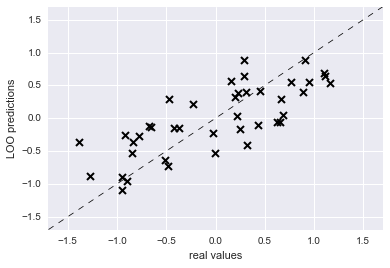

In [95]:
m = GPreg(X, F, d)
mloo, vloo = leaveOneOut(m)
mlto, vltoo = leaveTwoOut(m)
print 'Q2 measured for leave one out: ', Q2(F.flatten(),mloo.flatten())
print 'Q2 measured for leave two out: ', Q2(F.flatten(),mlto.flatten())

pb.figure()
pb.plot(F,mloo,'kx',mew=2)
pb.plot((-2,2),(-2,2),'k--',linewidth=.75)
pb.xlim((-1.7,1.7)), pb.ylim((-1.7,1.7))
pb.xlabel('real values'),pb.ylabel('LOO predictions')

### Optimization: Using expected improvement

In [96]:
##      expected improvement      ##
def EI(x,m): # expected improvement for deterministic model
    # x : matrix of input points
    # m : GPy GPR model
    x.flatten()
    x = x[None,:]
    m['.*noise'] = 0.0
    #print x.shape
    mean, var = m.predict(x)
    var[var<0] = 0
    u = (np.min(m.Y) - mean)/np.sqrt(var)
    ei = np.sqrt(var) * (u * sp.stats.norm.cdf(u) + sp.stats.norm.pdf(u))
    ei[np.isnan(ei)] = 0
    return ei

N = 1000
start_points = np.random.random_sample((N,4))
best_point = 0
mmin = -10000000.0
for i in range(0,N):
    ini = start_points[i,:].copy()
    mfun = EI(ini, m)
    #print ini.shape
    #optimizer = sp.optimize.minimize(EI, ini, args=(m))
    #print optimizer.fun
    #print optimizer.x
    if mfun > mmin:
        best_point = ini
        mmin = mfun


In [97]:
best_point_old = best_point[None,:]
super_best = best_point_old *(limits[1,:]-limits[0,:])[None,:] + limits[0:1,:]
bicho = new2old(super_best)
print bicho

[[  3.93122533   7.75411956   8.12359392  10.22273   ]]


In [98]:
def single_helico_str(X,expNumber,groupName):
    (Wl, Ww, Tl, Al) = X
    Aw = .7
    Tb = 1.
    Tw = 1.2
    lineHeight = .5

    helico_str = """\\makebox[%fcm]{
    \\begin{pspicture}(%f,%f)(%f,%f)
    \psline[linewidth=0.02](%f,%f)(%f,%f)(%f,%f)(%f,%f)(%f,%f)(%f,%f)(%f,%f)(%f,%f)
    \psline[linewidth=0.02](%f,%f)(%f,%f)(%f,%f)(%f,%f)(%f,%f)(%f,%f)(%f,%f)(%f,%f)
    \psline[linewidth=0.02](%f,%f)(%f,%f)
    \psline[linewidth=0.02, linestyle=dashed, dash=0.17cm 0.10cm](%f,%f)(%f,%f)
    \psline[linewidth=0.02, linestyle=dashed, dash=0.17cm 0.10cm](%f,%f)(%f,%f)
    \psline[linewidth=0.02, linestyle=dashed, dash=0.17cm 0.10cm](%f,%f)(%f,%f)
    \\rput[b](0,%f){\\footnotesize{%s}}
    \\rput[b](0,%f){\\footnotesize{exp %i}}
    \\rput[b](0,%f){\\footnotesize{$W_l = %.2f$}}
    \\rput[b](0,%f){\\footnotesize{$W_w = %.2f$ }}
    \\rput[b](0,%f){\\footnotesize{$T_l = %.2f$}}
    \\rput[b](0,%f){\\footnotesize{$A_l= %.2f$  }}
    \end{pspicture}
    }%%
    """ %(2*Ww,
        Ww,Wl+Al,-Ww,-Tl,
        0,Wl+Al, -Aw,Wl+Al, -Aw,Wl, -Ww,Wl, -Ww,0, -Tw,-Tb, -Tw,-Tl, 0,-Tl,
        0,Wl+Al,  Aw,Wl+Al,  Aw,Wl,  Ww,Wl,  Ww,0,  Tw,-Tb,  Tw,-Tl, 0,-Tl,
        0,Wl+Al,0,0,
        -Aw,Wl,Aw,Wl,
        -Ww,0,Ww,0,
        -Aw,Wl+Al-2.5,Aw,Wl+Al-2.5,
        -Tb-1,groupName,
        -Tb-1-lineHeight,expNumber,
        -Tb-1-2*lineHeight,Wl,
        -Tb-1-3*lineHeight,Ww,
        -Tb-1-4*lineHeight,Tl,
        -Tb-1-5*lineHeight,Al)
    
    return(helico_str)


def writeLaTeX(X,groupName):
    # inputs:   X, Design of Experiments, a (n,4) np.array
    #           groupName, a string (escape LaTeX characters such as \ _ etc)
    # output:   write a file 'helicopters.tex'
    f = open('helicopters2.tex', 'w')

    f.write( """\documentclass{article}
    \usepackage[usenames,dvipsnames]{pstricks}
    \usepackage[margin=7mm,paperheight=33cm,paperwidth=21.6cm]{geometry}
    \\begin{document} 
    \\raggedbottom 
    """)
    
    wleft = 19.5
    for i in range(X.shape[0]):
        if 2*X[i,1] < wleft:
            f.write(single_helico_str(X[i,:],i+1,groupName))
        else:
            wleft = 19.5
            f.write("\n \n" + single_helico_str(X[i,:],i+1,groupName))
        wleft -= 2*X[i,1]

    f.write('\end{document}')
    f.close()

writeLaTeX(bicho, 'JG')

ValueError: could not broadcast input array from shape (4) into shape (1)